# Simulation von Gaußstrahlen

## Inhaltsverzeichnis

## Allgemeines

In [1]:
"""Pakete"""

import io          # Input-Output
import locale          # Systemsprache
import matplotlib        # Mathebibliothek
import matplotlib.pyplot as plt      # Plotten
import matplotlib.ticker as tic      # Ticks für Plots
import numpy as np        # Mathezeug
import os          # Betriebssystemzeug
import pickle          # Zum "einlegen" von Daten wie Fitparameter
#import re          # Reguläre Ausdrücke Regex
from scipy.optimize import curve_fit as fit  #Fitten
import sympy as sp        # Symbolische Mathematik

In [2]:
"""Funktionen"""

def pl(log="", leg=True, name="", xname="", minor=True, dpi=150, savedpi="figure", axes=None, **kwargs):
    """
    Configure the standard plot with ticks all around, which point inwards.

    Requires matplotlib as plt.

    Parameters
    -----------
    log : str, optional
        Names of axes for which a logarithmic scale should be applied. Default is "".
    leg : bool, optional
        Wether a legend should be shown. The default is True.
    name : str, optional
        Filename to save the plot to.
    xname : str, optional
        Do nothing. It is a simple method to deactivate saving: change 'name' to 'xname'.
    minor : bool, optional
        Show minor ticks. Default is True.
    dpi : int, optional
        Dpi value for display. Default is 150
    savedpi : bool or "figure", optional
        Dpi value for saving the image. If "figure", the same value as `dpi` is taken.
        Default is "figure".
    axes : axes object, optional
        axes object which should be modified. If not supplied, the current object is taken.
    kwargs : dict, optional
        Further values are handed to the legend.
    """

    if axes is None:
        axes = plt.gca()  # Define the current axes object

    if minor:  # Minorticks
        axes.minorticks_on()

    axes.tick_params(axis="both", which="both", direction="in", top="true", right="true")

    # Logarithmic Axes
    if log != "":
        assert log == "x" or log == "y" or log == "both", "invalid axis parameter"
        axes.tick_params(axis=log, which="both", direction="in", top="true", right="true")
    if log == "x":
        axes.set_xscale("log")
    if log == "y":
        axes.set_yscale("log")
    if log == "both":
        axes.set_xscale("log")
        axes.set_yscale("log")

    if leg:  # Legend
        axes.legend(**kwargs)

    if name != "":  # Save file
        plt.savefig(fname=name, dpi=savedpi, bbox_inches='tight')

    plt.tight_layout()  # In order to fit the plot better into the present space.
    plt.show

In [3]:
"""Standard Definitionen zum Plotten"""

# Achsenformatierung auf Deutsch
Deutsch = False
if Deutsch:  # Deutsch
    # Festlegung der Systemsprache
    locale.setlocale(locale.LC_ALL, 'deu_deu' )  # Windows: "deu_deu", Linux: "de_DE.utf8"

# Achsenformatierung gemäß Systemsprache
matplotlib.rcParams['axes.formatter.use_locale'] = Deutsch


# Für das Laborbuch (0) die Arbeit (1) oder den Vortrag (2)
Ziel = 0
if Ziel == 1:  # Arbeit
    # Als pdf speichern
    matplotlib.rcParams['savefig.format'] = 'pdf'
    # Schrift auf AG-Design
    matplotlib.rcParams['font.size'] = 11
    matplotlib.rcParams['font.family'] = 'serif'
elif Ziel == 2:  # Präsentation
    # als png speichern
    matplotlib.rcParams['savefig.format'] = 'png'
    # größere Schrift
    matplotlib.rcParams['font.size'] = 20
else:  # Default für Laborbuch
    # Als png speichern
    matplotlib.rcParams['savefig.format'] = 'png'
    # Schrift auf AG-Design
    matplotlib.rcParams['font.size'] = 11
    matplotlib.rcParams['font.family'] = 'serif'
    
    

# Schöne Ausgabe von Sympy:
#sp.init_printing()

## Hilfreiche Funktionen und Definitionen

Strahlparameter $q = z-iz_R$

Rayleigh Länge $z_R = \frac{\pi w_0^2}{\lambda} n$

Strahlradius $w(z) = w_0 \sqrt{1+\left(\frac{z}{z_R}\right)^2} = w_0 \sqrt{1+\frac{z^2 \lambda^2}{(\pi w_0^2 n)^2}}$

Strahlradius $w(z) = \sqrt{\frac{2}{k \Im\frac1{q}}}$ mit dem Wellenvektor $k$

dünne Linse $\begin{pmatrix}1 & 0 \\ -f^{-1} & 1\end{pmatrix}$

Propagation $\begin{pmatrix}1 & \frac{d}{n} \\ 0 & 1\end{pmatrix}$

Spiegel $\begin{pmatrix} 1 & 0 \\ \frac{2}{R} & 1 \end{pmatrix}$, Krümmungsradius $R$

Brechung an Oberfläche $\begin{pmatrix} 1 & 0 \\ \frac{n_1 - n_2}{n_2 R} & \frac{n_1}{n_2} \end{pmatrix}$, Krümmungsradius $R$, Brechungsindizes $n_1, n_2$

In [37]:
def zRW0(w0, lbd, n=1):
    """Rayleigh-Länge abhängig vom Radius im Fokus `w0`, Wellenlänge `lbd` und Brechungsindex `n`."""
    return np.pi * w0**2 * n / lbd

def w0Zr(zR, lbd, n=1):
    """Strahltaille abhängig von Rayleighlänge `zR`, Wellenlänge `lbd` und Brechungsindex `n`."""
    return np.sqrt(zR * lbd / np.pi / n)

def wZr(z, zR, lbd, n=1):
    """Strahlradius abhängig von Position z, Rayleighlänge zR, Wellenlänge lbd und Brechungsindex n."""
    return w0Zr(zR, lbd, n) * np.sqrt(1 + (z/zR)**2)

def wW0(z, w0, lbd, n=1):
    """Strahlradius abhängig von Position z, Strahltaille w0, Wellenlänge lbd und Brechungsindex n."""
    return w0 * np.sqrt(1 + z**2 * lbd**2 / (np.pi * w0**2 * n)**2)

def modQ(q, M):
    """Modifizierung des Strahlparameters `q` mit der Matrix `M`."""
    return (q * M[0, 0] + M[0, 1]) / (q * M[1, 0], + M[1, 1])

def Linse(q, f):
    """Bestimmung des Strahlparameters nach einer Linse mit Brennweite `f` in m."""
    return q / (- q / f +1)

def Propagation(q, d, n=1):
    """Strahlparameter nach Distanz d."""
    return q+d/n 

In [38]:
# Parameter
f = 500 * 1e-3# m Brennweite
r = 4e-3  # Größe im Fokus direkt an Linse (kollimiert)
lambd = 1064e-9  # Wellenlänge in m

q2 = -1j * zRW0(r, lambd) / (-1 * 1j * zRW0(r, lambd)/f + 1)

print(f"Neue Strahltaille ist {w0Zr(-q2.imag, lambd)*1000}mm")

Neue Strahltaille ist 0.042332843931842584mm


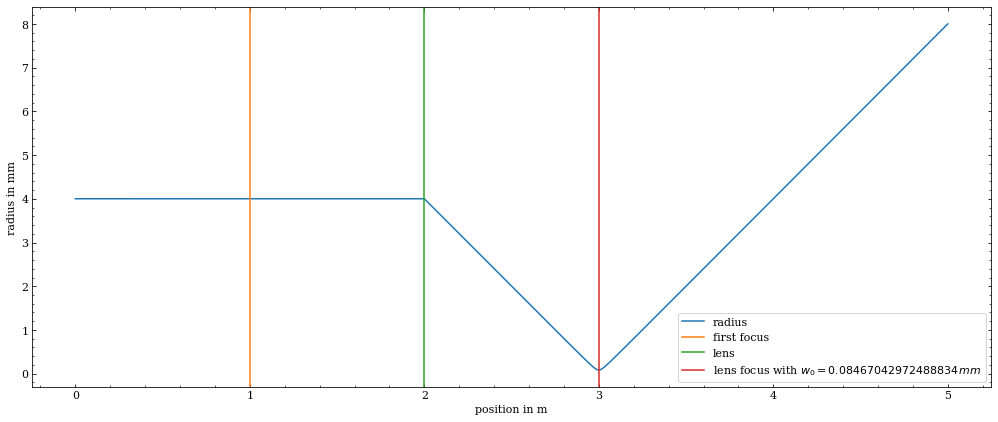

In [78]:
"""Plot"""
# Parameter, alles in m
w0 = 4e-3  # Strahltaille des Ursprungsstrahls
z0 = 1  # Position des ersten Fokus
lbd = 1064e-9  # Wellenlänge

zL = 2  # Position der Linse
f = 1  # Brennweite

zF = 5  # Länge der Simulation
N = 1000  # Anzahl der Punkte

# Plot
z = np.linspace(0, zF, N)
w = np.zeros_like(z)
border = int(zL / zF * N)
w[0:border] = wZr(z[0:border] -z0, zRW0(w0, lbd), lbd)

qL = Linse( zL - z0 - 1j * zRW0(w0, lbd), f)  # immediately after the lens
w[border:] = wZr(z[border:] - zL + qL.real, -qL.imag, lbd)
zLensF = zL - qL.real  # position of second focus

plt.figure(figsize=(14,6))
ax = plt.gca()
ax.plot(z, w*1000, label="radius")
if z0>0:
    ax.axvline(z0, label="first focus", color="C1")
ax.axvline(zL, label="lens", color="C2")
if zLensF < zF:
    ax.axvline(zLensF, label=f"lens focus with $w_0={w0Zr(-qL.imag, lbd)*1000:4}\,mm$", color="C3")
ax.set_xlabel("position in m")
ax.set_ylabel("radius in mm")
pl(leg=True, log='')

## Hilfreiche Tipps

In [ ]:
"""Daten lesen und schreiben"""

# Arbeitspfad:
Pfad = os.path.normpath("D:/Users/Testuser/Dokumente/ichHabeKeinenPlan/")
# os.sep ist der Betriebssystem Seperator von Ordnern


# Array aus ASCII einlesen
  # Kommata durch Punkte ersetzen
with open("Dateipfad") as file:
    Array = np.loadtxt(io.StringIO(file.read().replace(',','.')))
  # Andernfalls
Array=np.loadtxt("Dateipfad")


#Dateien schreiben:
with open("Dateipfad", "w") as file:
  file.write("Was man schreiben will")
               
# "eingelegte" Daten lesen und als Objekt speichern
with open("Dateipfad.pkl", "rb") as file:  # rb=read binary
    Objekt=pickle.load(file)      # Objekt kann ein Tupel aus Arrays sein

# Daten als ein Objekt "einlegen", zum Beispiel ist Objekt (Array1,String2,xy3):
with open("Dateipfad.pkl", "wb") as file:
  pickle.dump(Objekt, file)

In [ ]:
"""Plotten"""
width = 8  # cm
width /= 2.54  # In Zoll umrechnen
height = .75 * width

plt.figure(figsize=(width, height))  # Neue Figure, mit Achsenobjekt
ax = plt.gca()  # get current axes: Achsenobjekt erhalten
ax.plot(xArray, yArray, label="dF/dS", ls=":", marker="+", color="C3")  # die dritte Farbe im normalen Set
ax.set_xlabel("Frequenz in MHz")
ax.set_ylabel("Frequenzänderung in kHz/Skaleneinheit")

"""
Achsen beschriften mittels Kalibrierung:
- `x` ist die gemessene Größe (Werte des x/yArrays).
- `pos` ist die Position des Mauszeigers, für statische Werte irrelevant.
- `Faktor` ist die Umrechnung: Faktor=Neue Einheit/[x]
- `Skalenschritt` ist der Abstand (in der neuen Einheit) zwischen zwei Ticks
"""
ax.yaxis.set_major_formatter(tic.FuncFormatter(lambda x,pos: f"{x*Faktor:1.0f}"))  # x ist der Wert, pos die Mausposition
ax.yaxis.set_major_locator(plt.MultipleLocator(Skalenschritt/Faktor))

pl()  #Meine Plotsachen

"""Weitere y-Achse"""
ax2 = ax.twinx()